In [1]:
# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

# Load required packages -----------------------------------------------------------------
library(tidyverse) 
library(tidytext)
library(tidyr)
library(lexicon)
library(quanteda)

# Input data files are available in the read-only "../input/" directory ------------------

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved 
# as output when you create a version using "⟳ Save & Run All". From the resulting output
# section in the Viewer you can submit an output file as your entry to the competition.
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of 
# the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Package version: 3.0.0
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 4 of 4 threads used.

See https://quanteda.io for tutorials and examples.



[1] "bda2021big5"

There are three .csv files in the directory structure:

In [2]:
# directory content ------------------------------------------------------------------------

directory_content = list.files("../input/bda2021big5/youtube-personality", full.names = TRUE)
print(directory_content)

[1] "../input/bda2021big5/youtube-personality/README.txt"                                                 
[2] "../input/bda2021big5/youtube-personality/transcripts"                                                
[3] "../input/bda2021big5/youtube-personality/YouTube-Personality-audiovisual_features.csv"               
[4] "../input/bda2021big5/youtube-personality/YouTube-Personality-gender.csv"                             
[5] "../input/bda2021big5/youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv"


In addition there's a "transcript" folder (see number \[2\] in the output above) in which the actual video transcripts are stored in `.txt` files. 

Store these file paths in variables for easy reference later on:

In [3]:
# Path to the transcripts directory with transcript .txt files ------------------------

path_to_transcripts = directory_content[2] 

# .csv filenames (see output above)
AudioVisual_file    = directory_content[3]
Gender_file         = directory_content[4]
Personality_file    = directory_content[5]

# 1. Import the data

We'll import

- Transcripts
- Personality scores
- Gender

## 1.1 Importing transcripts

The transcript text files are stored in the subfolder 'transcripts'. They can be listed with the following commands:

In [4]:
# transcripts -----------------------------------------------------------------------

transcript_files = list.files(path_to_transcripts, full.names = TRUE) 

print(head(transcript_files))

[1] "../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt"  
[2] "../input/bda2021big5/youtube-personality/transcripts/VLOG10.txt" 
[3] "../input/bda2021big5/youtube-personality/transcripts/VLOG100.txt"
[4] "../input/bda2021big5/youtube-personality/transcripts/VLOG102.txt"
[5] "../input/bda2021big5/youtube-personality/transcripts/VLOG103.txt"
[6] "../input/bda2021big5/youtube-personality/transcripts/VLOG104.txt"


The transcript file names encode the vlogger ID that you will need for joining information from the different data frames. A clean way to extract the vlogger ID's from the names is by using the funcation `basename()` and removing the file extension ".txt".

In [5]:
# vloggers id ---------------------------------------------------------------------

vlogId = basename(transcript_files)
vlogId = str_replace(vlogId, pattern = ".txt$", replacement = "")
head(vlogId)

[1] "VLOG1"   "VLOG10"  "VLOG100" "VLOG102" "VLOG103" "VLOG104"

To include features extracted from the transcript texts you will have to read the text from files and store them in a data frame. For this, you will need the full file paths as stored in `transcript_files`.

Here are some tips to do that programmatically

- use either a `for` loop, the `sapply()` function, or the `map_chr()` from the `tidyverse`
- don't forget to also store `vlogId` extracted with the code above 

We will use the `map_chr()` function here:

In [6]:
transcripts_df = tibble(
    
    # vlogId connects each transcripts to a vlogger
    vlogId = vlogId,
    
    # Read the transcript text from all file and store as a string
    Text = map_chr(transcript_files, ~ paste(readLines(.x), collapse = "\\n")), 
    
    # `filename` keeps track of the specific video transcript
    filename = transcript_files
)

transcripts_df %>% 
    head(1)

Warning message in readLines(.x):
“incomplete final line found on '../input/bda2021big5/youtube-personality/transcripts/VLOG11.txt'”


vlogId,Text,filename
<chr>,<chr>,<chr>
VLOG1,"You know what I see - - no, more like hear a lot these days, is people calling other people gay as an insult. Now what makes people come up with calling others gay? Now here's an example. Hey, hey, you wanna trade Pokemon or Ziegfield cards? Or, or, or we can play, we can play superheroes. Oh, can I be Optimus Prime? Dude, you are so gay. Dude, the cool kids do crack. Oh, my mommy says, say no to drugs. Okay, how the hell does playing Pokemon cards or -- or --- or dancing or holding hands with another guy make me homosexual? I don't get these people. \nThis is how it is in my school. Okay, here's an example. All right, um, when they see two guys are gay, they're together, they're like no, ew, no. No, no that -- that doesn't go together - - you know, two guys, no. two sticks, no. It just doesn't work like . But when they see two girls, they're like, get it on. And I don't get these people. I've never seen someone say like, oh, you're so homosexual or you're so lesbian or you're such a child molester. It is always the word gay, cause apparently gay is now an insult, even though the word means like happy and lively and that kinda giddy feeling you have inside, like -- -- but no you have to turn that happy word into a mean word. Apparently, we can do that now, turning good things into bad things. It's like how Spiderman felt good, but then that -- that -- that grease that gets all over him and then and then evil Dr. Octopus. That's so gay, you like Spiderman. Lar, I'm going to the movies with the guys to watch Mama Mia. \nYou never know if other people are offended by what you say. I'm not saying you're a bad person if you do it. I used to do it all the time. I'm more focused on why we say it. In the end, we're all the same. You know, there's nothing wrong with it. I was just wondering where it all came from, you know. All right, thanks a lot for watching. Oh, yeah and the club channel is up and running. So, make sure to check that out because there's gonna be a lot of cool stuff on there. We'll do up to like four challenges at a time. We'll do contests, dares, questions. In the end, there's gonna be a lot of viewer interactions, so it's gonna be really fun. We may even put other people on the video too. So check it.",../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt


## Import personality scores

The other data files can be read in with `read_delim` (not `read_csv` because the files are not actually comma separated). For instance, the following should work:

In [7]:
# Import the Personality scores --------------------------------------------------------

pers_df = read_delim(Personality_file, delim = " ")
behavioural = read_delim(AudioVisual_file, delim = " ")

# look at the scores
head(pers_df)

Rows: 324 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr (1): vlogId
dbl (5): Extr, Agr, Cons, Emot, Open


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 404 Columns: 26

── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): vlogId
dbl (25): mean.pitch, sd.pitch, mean.conf.pitch, sd.conf.pitch, mean.spec.en...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



vlogId,Extr,Agr,Cons,Emot,Open
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VLOG1,4.9,3.7,3.6,3.2,5.5
VLOG3,5.0,5.0,4.6,5.3,4.4
VLOG5,5.9,5.3,5.3,5.8,5.5
VLOG6,5.4,4.8,4.4,4.8,5.7
VLOG7,4.7,5.1,4.4,5.1,4.7
VLOG9,5.6,5.0,4.0,4.2,4.9


## Import gender

Gender info is stored in a separate `.csv` which is also delimited with a space. This file doesn't have column names, so we have to add them ourselves:

In [8]:
# import gender information -----------------------------------------------------------------------------------

gender_df = read.delim(Gender_file, head = FALSE, sep = " ", skip = 2)

# Add column names
names(gender_df) = c('vlogId', 'gender')

head(gender_df)

,vlogId,gender
,<chr>,<chr>
1,VLOG3,Female
2,VLOG5,Male
3,VLOG6,Male
4,VLOG7,Male
5,VLOG8,Female
6,VLOG9,Female


## Merging the `gender` and `pers` dataframes

Obviously, we want all the information in a single tidy data frame. While the builtin R function `merge()` can do that, the `tidyverse()` has a number of more versatile and consistent functions called `left_join`, `right_join`, `inner_join`, `outer_join`, and `anti_join`. We'll use `left_join` here to merge the gender and personality data frames:

In [9]:
# merge dataframes ------------------------------------------------------------------

vlogger_df = left_join(gender_df, pers_df)

head(vlogger_df) # VLOG8 has missing personality scores: those should be predicted

Joining, by = "vlogId"



,vlogId,gender,Extr,Agr,Cons,Emot,Open
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,VLOG3,Female,5.0,5.0,4.6,5.3,4.4
2,VLOG5,Male,5.9,5.3,5.3,5.8,5.5
3,VLOG6,Male,5.4,4.8,4.4,4.8,5.7
4,VLOG7,Male,4.7,5.1,4.4,5.1,4.7
5,VLOG8,Female,NA,NA,NA,NA,NA
6,VLOG9,Female,5.6,5.0,4.0,4.2,4.9


Note that some rows, like row 5, has `NA`'s for the personality scores. This is because this row corresponds to the vlogger with vlogId `VLOG8` is part of the test set. You still have to split `vlogger_df` into the training and test set, as shown below.

We leave the `transcripts_df` data frame seperate for now, because you will first have to extract features from the transcripts first. Once you have those features in a tidy data frame, including a `vlogId` column, you can refer to this `left_join` example to merge your features with `vlogger_df` in one single tidy data frame.

# 2. Feature extraction from transcript texts

Here you will develop the code that extract features from the transcript texts using `tidytext`. Look at [Introducing Text Analytics](https://www.kaggle.com/datasniffer/introducing-text-analytics-personality-from-text) to see how you should do this.

word,lexicon
<chr>,<chr>
i,snowball
me,snowball
my,snowball
myself,snowball
we,snowball
our,snowball


vlogId,filename,token
<chr>,<chr>,<chr>
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,know
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,see
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,like
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,hear
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,lot
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,days


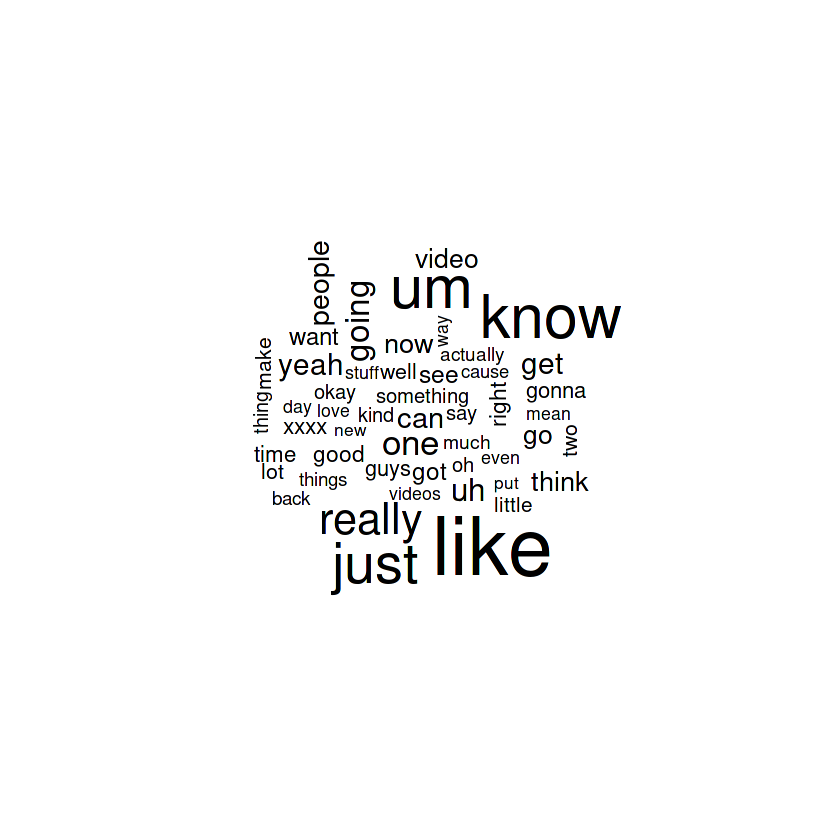

In [10]:
# Compute the dataframe `transcript_tokenenized` ---------------------------------------------------------

# Token for words ----------------------------------------
transcripts_token = transcripts_df %>% 
    unnest_tokens(token, Text, token = 'words')

# Token for sentences ------------------------------------
transcripts_sentence = transcripts_df %>% 
        unnest_tokens(sentence, Text, token = 'sentences')

# Adding stopwords ---------------------------------------
stopwords = get_stopwords() 
head(stopwords)

transcripts_tokenized = transcripts_token %>% 
    anti_join(stopwords, by = c(token = "word"))

# peek at the result -------------------------------------
head(transcripts_tokenized)

# Dataframe ----------------------------------------------------------------------------------------------

transcripts_tokenized %>%
# count tokens (sort according to number of occurences)
    count(token, sort=TRUE) %>%
        with(., wordcloud::wordcloud(token, n, max.words = 50))


# 2.1. Feature extraction

# Feature Selection Criterion

Features were extracted based on the article by Yarkoni, T. (2010). Personality in 100,000 Words, it explains how certain type, count and lenght of words explain the each of the Big 5 personality charachter traits. The following features were selected:
1. Affin score: Rates a word positive or negative (based on a scale), Neurotic individuals use more negative words. 
2. Curse words : Curse words are used less by conscious individuals
3. Preposition: Individuals who are open will use more preposition 
4. Pronouns: Individuals who are more agreeable would use more pronouns 
5. NRC scores: Shows different levels of emotions 
6. Words per sentence: Extroverted individuals have more words in thier sentence
7. Word lenght: Individuals who are agreeable use longer words
8. Speaking time: Extroverted individuals speak for longer time
9. Action words: Open individuals use more action words

Source: Yarkoni, T. (2010). Personality in 100,000 Words: A large-scale analysis of personality and word use among bloggers. Journal of Research in Personality, 44 (3), 363-373 DOI: 10.1016/j.jrp.2010.04.001

In [11]:
# The AFINN word list has to be downloaded and unzipped --------------------

download.file("http://www2.imm.dtu.dk/pubdb/edoc/imm6010.zip","afinn.zip")
unzip("afinn.zip")
afinn = read.delim("AFINN/AFINN-111.txt", 
                   sep = "\t", 
                   col.names = c("word","score"), 
                   stringsAsFactors = FALSE)

# joining afinn scores to the transcripts ----------------------------------

essay_token_afinn = 
    left_join(transcripts_tokenized, afinn, by = c(token = 'word')) 

no_na = essay_token_afinn %>%
    drop_na()

# dataframe including afinn scores -----------------------------------------

afinn_group = no_na %>%
    group_by(vlogId) %>%
      summarise(score = mean(score))




In [12]:

# curse words list -------------------------------------------------------------------------

data(profanity_banned)
curse = NULL

# search for cursewords in transcripts -----------------------------------------------------

for (i in 1:nrow(transcripts_tokenized)) {
     if (transcripts_tokenized$token[i] %in% profanity_banned) {
        curse[i] = 1
     } else {
         curse[i] = 0
     }
 }

curse_token = cbind(transcripts_tokenized, curse)
curse_volg = curse_token %>%
    group_by(vlogId) %>%
        summarise(curse = sum(curse))

# Final list of cursewords 
curse_volg

vlogId,curse
<chr>,<dbl>
VLOG1,1
VLOG10,1
VLOG100,0
VLOG102,0
VLOG103,0
VLOG104,0
VLOG105,0
VLOG106,4
VLOG107,0


In [13]:
# prepositions include the stop words as well -------------------------------------

transcripts_token
data(pos_preposition)
prep = NULL

for (i in 1:nrow(transcripts_token)) {
     if (transcripts_token$token[i] %in% pos_preposition) {
        prep[i] = 1
     } else {
        prep[i] = 0
     }
 }

prep_token = cbind(transcripts_token, prep)

prep_volg = prep_token %>%
    group_by(vlogId) %>%
      summarise(preposition = sum(prep))
prep_volg

# pronouns ------------------------------------------------------------------------

data(pos_df_pronouns)
pronoun = NULL

for (i in 1:nrow(transcripts_token)) {
     if (transcripts_token$token[i] %in% pos_df_pronouns$pronoun) {
        pronoun[i] = 1
     } else {
        pronoun[i] = 0
     }
 }

pronoun_token = cbind(transcripts_token, pronoun)
pronoun_volg = pronoun_token %>%
    group_by(vlogId) %>%
        summarise(pronoun = sum(pronoun))
pronoun_volg

# action --------------------------------------------------------------------------

data(pos_action_verb)
action = NULL

for (i in 1:nrow(transcripts_token)) {
     if (transcripts_token$token[i] %in% pos_action_verb) {
         action[i] = 1
     } else {
        action[i] = 0
     }
 }

action_token = cbind(transcripts_token, action)
action_volg = action_token %>%
    group_by(vlogId) %>%
      summarise(action = sum(action))
action_volg

# NRC -----------------------------------------------------------------------------

load_nrc = function() {
    if (!file.exists('nrc.txt'))
        download.file("https://www.dropbox.com/s/yo5o476zk8j5ujg/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt?dl=1","nrc.txt")
        nrc = read.table("nrc.txt", 
                         col.names = c('word','sentiment','applies'), 
                         stringsAsFactors = FALSE)
        nrc %>% 
            filter(applies == 1) %>% 
                select(-applies)
}

nrc = load_nrc()

# join with the dataset -----------------------------------------------------------

transcripts_labeled = inner_join(transcripts_tokenized, nrc, 
                                 by = c(token = 'word')) 
sentiment_scores = transcripts_labeled %>% 
    count(`vlogId`, sentiment) 

# spread the table ----------------------------------------------------------------
sentiment_vlog = sentiment_scores %>%
    spread(sentiment, n, fill = 0)

# result 
sentiment_vlog %>% 
    head()

# words per sentence --------------------------------------------------------------

head(transcripts_sentence)

transcripts_sentence$sentence = ntoken(x = transcripts_sentence$sentence, 
                                       remove_punct = TRUE)

# Calculate the average amount of words per sentence per vlog ---------------------

sentence_meanscores = transcripts_sentence %>%
    group_by(vlogId) %>%
        summarise(mean_n_words = mean(sentence)) 

head(sentence_meanscores)

vlogId,filename,token
<chr>,<chr>,<chr>
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,you
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,know
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,what
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,i
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,see
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,no
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,more
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,like
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,hear


vlogId,preposition
<chr>,<dbl>
VLOG1,54
VLOG10,69
VLOG100,40
VLOG102,197
VLOG103,116
VLOG104,149
VLOG105,65
VLOG106,84
VLOG107,138


vlogId,pronoun
<chr>,<dbl>
VLOG1,32
VLOG10,24
VLOG100,33
VLOG102,86
VLOG103,47
VLOG104,46
VLOG105,32
VLOG106,65
VLOG107,77


vlogId,action
<chr>,<dbl>
VLOG1,47
VLOG10,45
VLOG100,18
VLOG102,160
VLOG103,83
VLOG104,89
VLOG105,39
VLOG106,66
VLOG107,77


vlogId,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VLOG1,8,10,8,6,7,10,14,8,5,11
VLOG10,10,19,7,14,9,18,19,8,10,17
VLOG100,0,9,0,2,8,3,11,1,2,9
VLOG102,4,50,7,14,29,14,42,8,22,24
VLOG103,0,19,4,9,13,15,26,10,5,11
VLOG104,2,15,0,4,49,3,62,22,9,37


vlogId,filename,sentence
<chr>,<chr>,<chr>
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,"you know what i see - - no, more like hear a lot these days, is people calling other people gay as an insult."
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,now what makes people come up with calling others gay?
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,now here's an example.
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,"hey, hey, you wanna trade pokemon or ziegfield cards?"
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,"or, or, or we can play, we can play superheroes."
VLOG1,../input/bda2021big5/youtube-personality/transcripts/VLOG1.txt,"oh, can i be optimus prime?"


vlogId,mean_n_words
<chr>,<dbl>
VLOG1,11.44737
VLOG10,21.38095
VLOG100,24.41667
VLOG102,10.51562
VLOG103,11.30882
VLOG104,29.18519


In [14]:
# did not include stop words -- as these are not essential for each sentence ------

al_words = transcripts_tokenized %>%
    group_by(vlogId) %>%
        distinct(token, .keep_all = TRUE)

# word lenght only unique words ---------------------------------------------------

word_lengths = al_words %>%
    mutate(word_length = nchar(token))

nrow(word_lengths)
nrow(al_words)

# combining datasets --------------------------------------------------------------

word_volg = word_lengths %>%
    group_by(vlogId) %>%
      summarise(word = mean(word_length))
word_volg


# speaking_time -------------------------------------------------------------------

speaking_time = behavioural %>% 
    select(vlogId, time.speaking)
speaking_time


[1] 64943

[1] 64943

vlogId,word
<chr>,<dbl>
VLOG1,5.206107
VLOG10,5.934673
VLOG100,5.359551
VLOG102,5.446875
VLOG103,5.133333
VLOG104,5.840000
VLOG105,5.604478
VLOG106,5.269231
VLOG107,5.732218


vlogId,time.speaking
<chr>,<dbl>
VLOG1,0.60796
VLOG3,0.51374
VLOG5,0.70205
VLOG6,0.75993
VLOG7,0.60069
VLOG8,0.46439
VLOG9,0.67458
VLOG10,0.76182
VLOG11,0.51080


Once you have computed features from the transcript texts and stored it in a data frame, merge it with the `vlogger_df` dataframe:

In [15]:
# merge `vlogger_df` -------------------------------------------------------------

vlogger_df = left_join(gender_df,pers_df,by = "vlogId") %>%
    left_join(curse_volg, by = "vlogId") %>%
      left_join(prep_volg, by = "vlogId") %>%
          left_join( word_volg, by = "vlogId") %>%
            left_join( afinn_group, by = "vlogId") %>%
                left_join( pronoun_volg, by = "vlogId") %>%
                    left_join(action_volg, by = "vlogId") %>%
                        left_join(sentiment_vlog, by = "vlogId") %>%
                            left_join(speaking_time, by = "vlogId")  %>%
                                left_join(sentence_meanscores, by = "vlogId") 

head(vlogger_df)


,vlogId,gender,Extr,Agr,Cons,Emot,Open,curse,preposition,word,⋯,disgust,fear,joy,negative,positive,sadness,surprise,trust,time.speaking,mean_n_words
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,VLOG3,Female,5.0,5.0,4.6,5.3,4.4,0,46,5.169118,⋯,2,2,7,2,10,4,6,9,0.51374,18.750000
2,VLOG5,Male,5.9,5.3,5.3,5.8,5.5,0,65,5.254098,⋯,1,2,4,1,10,1,4,5,0.70205,19.750000
3,VLOG6,Male,5.4,4.8,4.4,4.8,5.7,0,103,5.639175,⋯,4,4,19,12,29,3,11,24,0.75993,22.214286
4,VLOG7,Male,4.7,5.1,4.4,5.1,4.7,1,89,5.615764,⋯,11,7,12,15,21,11,9,16,0.60069,16.947368
5,VLOG8,Female,NA,NA,NA,NA,NA,0,42,4.981132,⋯,2,6,7,5,12,4,3,9,0.46439,7.404762
6,VLOG9,Female,5.6,5.0,4.0,4.2,4.9,0,133,5.591093,⋯,8,8,15,18,30,5,11,21,0.67458,14.311475


# 3. Predictive model

Next you fit your predictive model(s). For instance, a linear regression model that only uses `gender` a feature might be:

In [16]:
# full model -------------------------------------------------------------------------------

fit = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking + anger + anticipation + disgust + fear + joy +
            negative + positive + sadness + surprise + trust + mean_n_words, 
            data = vlogger_df)

summary(fit)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking + anger + anticipation + 
    disgust + fear + joy + negative + positive + sadness + surprise + 
    trust + mean_n_words, data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.31969 -0.66538  0.02569  0.68193  1.87198 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.619929   1.094990   3.306  0.00106 ** 
curse          0.036528   0.028888   1.264  0.20703    
preposition   -0.003450   0.002894  -1.192  0.23418    
word          -0.015219   0.215346  -0.071  0.94371    
score          0.027006   0.093321   0.289  0.77248    
pronoun        0.010237   0.004106   2.493  0.01319 *  
action        -0.003003   0.004135  -0.726  0.46819    
genderMale     0.007751   0.109307   0.071  0.94352    
time.speaking  1.901655   0.389050   4.888 1.65e-06 ***
anger          0.004566   0.021467   0.213  0.83169 

In [17]:
# removing trust and surprise as they were insignificant for all DV -------------------------

fit_t = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking + anger + anticipation + disgust + fear + joy +
            negative + positive + sadness + mean_n_words,
            data = vlogger_df)

summary(fit_t)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking + anger + anticipation + 
    disgust + fear + joy + negative + positive + sadness + mean_n_words, 
    data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.33499 -0.65261 -0.01959  0.67809  1.77383 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.7145849  1.0913560   3.404 0.000754 ***
curse          0.0351128  0.0285968   1.228 0.220446    
preposition   -0.0035961  0.0028916  -1.244 0.214592    
word          -0.0421451  0.2143750  -0.197 0.844275    
score          0.0396018  0.0924432   0.428 0.668669    
pronoun        0.0103910  0.0040965   2.537 0.011694 *  
action        -0.0029017  0.0041320  -0.702 0.483048    
genderMale     0.0122670  0.1091770   0.112 0.910613    
time.speaking  1.9592600  0.3841068   5.101 5.95e-07 ***
anger          0.0034971  0.0214409   0.163 0.870542    
anti

In [18]:
# time.speaking and mean_n_words interaction -------------------------------------------------

fit_f = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking * mean_n_words + anger + anticipation + disgust + 
            fear + joy + negative + positive + sadness,
            data = vlogger_df)

summary(fit_f)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking * mean_n_words + anger + 
    anticipation + disgust + fear + joy + negative + positive + 
    sadness, data = vlogger_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2786 -0.6401 -0.0259  0.6550  1.8937 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 4.9316795  1.1689231   4.219 3.24e-05 ***
curse                       0.0234292  0.0286243   0.819  0.41371    
preposition                -0.0041752  0.0028696  -1.455  0.14671    
word                        0.0276391  0.2136992   0.129  0.89718    
score                       0.0498780  0.0915644   0.545  0.58634    
pronoun                     0.0111968  0.0040649   2.755  0.00623 ** 
action                     -0.0027961  0.0040894  -0.684  0.49465    
genderMale                  0.0316825  0.1082822   0.293  0.77003    
time.speaki

In [19]:
# removing positive -------------------------------------------------------------------------

fit_l = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking + anger + anticipation + disgust + fear + joy +
            negative + sadness + mean_n_words,
            data = vlogger_df)

summary(fit_l)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking + anger + anticipation + 
    disgust + fear + joy + negative + sadness + mean_n_words, 
    data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.33690 -0.65428 -0.03059  0.67675  1.79130 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.7812748  1.0469861   3.612 0.000356 ***
curse          0.0349536  0.0285432   1.225 0.221673    
preposition   -0.0037434  0.0028090  -1.333 0.183642    
word          -0.0550613  0.2058974  -0.267 0.789325    
score          0.0404657  0.0922165   0.439 0.661107    
pronoun        0.0103547  0.0040869   2.534 0.011787 *  
action        -0.0029815  0.0041097  -0.725 0.468721    
genderMale     0.0106734  0.1087680   0.098 0.921894    
time.speaking  1.9600895  0.3834908   5.111 5.65e-07 ***
anger          0.0035905  0.0214033   0.168 0.866889    
anticipation  -

In [20]:
# action removed-------------------------------------------------------------------------------------

fit_a = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            gender + time.speaking + anger + anticipation + disgust + fear + joy +
            negative + sadness + mean_n_words,
            data = vlogger_df)

summary(fit_a)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    gender + time.speaking + anger + anticipation + disgust + 
    fear + joy + negative + sadness + mean_n_words, data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.33943 -0.66029 -0.05049  0.66765  1.73589 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.7117196  1.0417823   3.563 0.000425 ***
curse          0.0366054  0.0284302   1.288 0.198872    
preposition   -0.0051082  0.0020844  -2.451 0.014817 *  
word          -0.0448538  0.2052575  -0.219 0.827166    
score          0.0416954  0.0921297   0.453 0.651176    
pronoun        0.0091463  0.0037291   2.453 0.014736 *  
genderMale     0.0111751  0.1086819   0.103 0.918170    
time.speaking  1.9554113  0.3831407   5.104 5.85e-07 ***
anger          0.0041469  0.0213731   0.194 0.846287    
anticipation  -0.0059992  0.0112436  -0.534 0.594025    
disgust        0.0033542  0.0

In [21]:
# joy+sadness removed ------------------------------------------------------------------------

fit_j = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            gender + time.speaking + anger + anticipation + disgust + fear +
            negative + mean_n_words,
            data = vlogger_df)

summary(fit_j)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    gender + time.speaking + anger + anticipation + disgust + 
    fear + negative + mean_n_words, data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.28420 -0.63449  0.01082  0.72308  1.89644 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.5738346  1.0428930   3.427 0.000693 ***
curse          0.0352693  0.0285027   1.237 0.216877    
preposition   -0.0045107  0.0020698  -2.179 0.030067 *  
word          -0.0230340  0.2056247  -0.112 0.910880    
score          0.0825776  0.0892431   0.925 0.355527    
pronoun        0.0093323  0.0037398   2.495 0.013104 *  
genderMale     0.0151313  0.1089991   0.139 0.889682    
time.speaking  1.9863154  0.3825673   5.192 3.78e-07 ***
anger          0.0073278  0.0213844   0.343 0.732080    
anticipation   0.0045683  0.0090054   0.507 0.612316    
disgust       -0.0024337  0.0210752  -0.115 0

In [22]:
# removing trust,disgust sadness and surprise as they were insignificant for all DV, using 
# time.speaking and mean_n_words interaction -------------------------------------------------

fit_i = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking * mean_n_words + anger + fear + joy +
            negative + positive,
            data = vlogger_df)

summary(fit_i)

Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking * mean_n_words + anger + 
    fear + joy + negative + positive, data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.25290 -0.64603  0.00221  0.73017  1.92601 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 4.853180   1.166820   4.159 4.15e-05 ***
curse                       0.024290   0.026798   0.906  0.36544    
preposition                -0.004120   0.002860  -1.440  0.15079    
word                        0.033772   0.213115   0.158  0.87419    
score                       0.056661   0.091137   0.622  0.53460    
pronoun                     0.011153   0.004051   2.753  0.00626 ** 
action                     -0.002666   0.003996  -0.667  0.50526    
genderMale                  0.035579   0.107643   0.331  0.74123    
time.speaking              -0.303247   0.928517  -

In [23]:
#Final model chosen based on the explanatory power of the model-----------------------------

#removing trust and surprise as they were insignificant for all DV 

fit_m = lm(cbind(Extr, Agr, Cons, Emot, Open) ~ curse + preposition + word + score + pronoun +
            action + gender + time.speaking + anger + anticipation + disgust + fear + joy +
            negative + positive + sadness + mean_n_words,
            data = vlogger_df)

summary(fit_m)



Response Extr :

Call:
lm(formula = Extr ~ curse + preposition + word + score + pronoun + 
    action + gender + time.speaking + anger + anticipation + 
    disgust + fear + joy + negative + positive + sadness + mean_n_words, 
    data = vlogger_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.33499 -0.65261 -0.01959  0.67809  1.77383 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.7145849  1.0913560   3.404 0.000754 ***
curse          0.0351128  0.0285968   1.228 0.220446    
preposition   -0.0035961  0.0028916  -1.244 0.214592    
word          -0.0421451  0.2143750  -0.197 0.844275    
score          0.0396018  0.0924432   0.428 0.668669    
pronoun        0.0103910  0.0040965   2.537 0.011694 *  
action        -0.0029017  0.0041320  -0.702 0.483048    
genderMale     0.0122670  0.1091770   0.112 0.910613    
time.speaking  1.9592600  0.3841068   5.101 5.95e-07 ***
anger          0.0034971  0.0214409   0.163 0.870542    
anti

# 4. Making predictions on the test set

For the competition we have to make **predictions** for the data in the **test set**

- The predictions will be evaluated by computing the **Root Means Square Error**:
    - $\displaystyle{RMSE =\sqrt{{1 \over 5n} \sum_{k \in \{cEXT, \ldots, cOPN\}} \sum_{i=1}^n (y_{ik} - \hat y_{ik})^2}}$
    - Here 
        - $y_{ik}$ is the observed value for vlogger $i$ 
        - $\hat y_{ik}$ is your prediction for vlogger $i$
        
        
You will have to take the following steps:

1. Extract the test set from the `vlogger_df`
2. Compute predictions for the test set using your model
3. Write those predictions to file in the right format

The following gives code for these steps in order.

## 4.1 The test set

The test set are those `vlogId` that are missing in the personality scores data frame `pers`. They are the rows in `vlogger_df` for which the personality scores are missing:

In [24]:
# compute test set ------------------------------------------------------------------------------

testset_vloggers = vlogger_df %>% 
    filter(is.na(Extr))

# have a look
head(testset_vloggers)

,vlogId,gender,Extr,Agr,Cons,Emot,Open,curse,preposition,word,⋯,disgust,fear,joy,negative,positive,sadness,surprise,trust,time.speaking,mean_n_words
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,VLOG8,Female,NA,NA,NA,NA,NA,0,42,4.981132,⋯,2,6,7,5,12,4,3,9,0.46439,7.404762
2,VLOG15,Male,NA,NA,NA,NA,NA,1,122,5.728395,⋯,3,10,14,14,30,5,13,36,0.71592,22.805556
3,VLOG18,Male,NA,NA,NA,NA,NA,0,50,5.474576,⋯,1,2,5,2,10,1,3,5,0.69587,16.050000
4,VLOG22,Female,NA,NA,NA,NA,NA,0,3,6.000000,⋯,1,0,1,0,1,0,1,1,0.42792,25.000000
5,VLOG28,Male,NA,NA,NA,NA,NA,0,42,4.850000,⋯,1,5,1,5,2,5,2,2,0.52014,10.708333
6,VLOG29,Female,NA,NA,NA,NA,NA,5,58,5.169811,⋯,3,1,15,7,24,1,10,17,0.63590,11.150000


## 4.2 Predictions

In [25]:
# calculate predictions -------------------------------------------------------------------
pred_mlm = predict(fit_m, 
                   new = testset_vloggers)

# look at the predictions
head(pred_mlm)

,Extr,Agr,Cons,Emot,Open
1,4.358779,4.948159,4.150433,4.721042,4.454992
2,4.411574,4.386255,4.744612,4.715052,4.568215
3,4.660525,4.770453,4.684469,4.920834,4.826829
4,3.952258,5.487484,4.901250,5.270427,4.548305
5,4.177366,4.134374,4.008058,4.177859,4.468396
6,5.091743,4.572375,4.181957,4.684875,4.643364


## 4.3 Dataframe

In [26]:
# compute output data frame ----------------------------------------------------
testset_pred = testset_vloggers %>% 
    mutate(
        Extr = pred_mlm[,'Extr'], 
        Agr  = pred_mlm[,'Agr' ],
        Cons = pred_mlm[,'Cons'],
        Emot = pred_mlm[,'Emot'],
        Open = pred_mlm[,'Open']
    ) %>%
    select(vlogId, Extr:Open)

# have a look
head(testset_pred)

,vlogId,Extr,Agr,Cons,Emot,Open
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,VLOG8,4.358779,4.948159,4.150433,4.721042,4.454992
2,VLOG15,4.411574,4.386255,4.744612,4.715052,4.568215
3,VLOG18,4.660525,4.770453,4.684469,4.920834,4.826829
4,VLOG22,3.952258,5.487484,4.901250,5.270427,4.548305
5,VLOG28,4.177366,4.134374,4.008058,4.177859,4.468396
6,VLOG29,5.091743,4.572375,4.181957,4.684875,4.643364


## 4.4 Writing predictions to file

You need to upload your predictions in .csv file. However, there are multiple columns: `Extr`, `Agr`, `Cons`, `Emot`, `Open`, while Kaggle expects **long format**!

What does long format look like?

- Every prediction on a single line.
- Columns `vlogId` and `pers_axis` to map prediction *vlogger ID* and *personality axis*.

To achieve this, first `gather` the column values into a single `value` column, adding a `pers_axis` to indicate the column name:

In [27]:
# prepare file ------------------------------------------------------------------
testset_pred_long  = testset_pred %>% 
    gather(pers_axis, Expected, -vlogId) %>%
        arrange(vlogId, pers_axis)

head(testset_pred_long)

,vlogId,pers_axis,Expected
,<chr>,<chr>,<dbl>
1,VLOG100,Agr,4.978815
2,VLOG100,Cons,4.640647
3,VLOG100,Emot,4.968888
4,VLOG100,Extr,4.441467
5,VLOG100,Open,4.800959
6,VLOG113,Agr,5.239854


According to the competition's [Evaluation instructions](https://www.kaggle.com/c/bda2019big5/overview/evaluation), Kaggle expects file with two colums: `Id` and `value`.
  
The [Evaluation instructions](https://www.kaggle.com/c/bda2019big5/overview/evaluation) specifies we need to encode the `Agr` prediction for `VLOG8` as `VLOG8_Agr` in the `Id` column. To achieve this use `unite()` function of `dplyr`.

`unite()` take:

- a data frame as its first argument (implicitely passed by the piping operator `%>%`)
- the name of new column as its second argument (`Id` below)
- all extra arguments (`vlogId` and `pers_axis` below) are concatenated with an underscore in between

Then write the resulting data frame to a .csv file.

In [28]:
# Obtain the right format for Kaggle ------------------------------------------------------------------
testset_pred_final = testset_pred_long %>%
    unite(Id, vlogId, pers_axis) 

# Check if we succeeded
head(testset_pred_final)

# Write to csv
testset_pred_final %>%
    write_csv(path = "predictions.csv")

# Check if the file was written successfully.
list.files()

,Id,Expected
,<chr>,<dbl>
1,VLOG100_Agr,4.978815
2,VLOG100_Cons,4.640647
3,VLOG100_Emot,4.968888
4,VLOG100_Extr,4.441467
5,VLOG100_Open,4.800959
6,VLOG113_Agr,5.239854


Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] "__notebook__.ipynb" "AFINN"              "afinn.zip"         
[4] "nrc.txt"            "predictions.csv"    "Rplot001.png"

Once you have clicked the <span style="background-color:#000000;color:white;padding:3px;border-radius:10px;padding-left:6px;padding-right:6px;">⟳ Save Version&nbsp;&nbsp;|&nbsp;&nbsp;0</span> button at the top left, and select the "Save & Run All (Commit)" option, go to the Viewer. There you will find your "predictions.csv" under Output. You'll also see a button there that allows you to submit your predictions with one click.